In [8]:
import re
import os
import io
import ast
import gzip
import glob

import numpy as np
import pandas as pd

import torch
import pyro.distributions as dist

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from path import Path

from tqdm.notebook import tqdm

In [9]:
latent_dim_dict = {
    'Arizona': 5, 
    'Atlanta': 7,
    'Baltimore': 15,
    'Buffalo': 25,
    'Carolina': 5, 
    'Chicago': 15,
    'Cincinnati': 13,
    'Cleveland': 11,
    'Dallas': 37,
    'Denver': 5,
    'Detroit': 12,
    'Green Bay': 52,
    'Houston': 12, 
    'Indianapolis': 10, 
    'Jacksonville': 12,
    'Kansas City': 11,
    'Las Vegas': 12,
    'LA Chargers': 5,
    'LA Rams': 10,
    'Miami': 8,
    'Minnesota': 5, 
    'New England': 9, 
    'New Orleans': 18 ,
    'NY Giants': 7,
    'NY Jets': 7,
    'Philadelphia': 10,
    'Pittsburgh': 25,
    'San Francisco': 12,
    'Seattle': 14,
    'Tampa Bay': 15,
    'Tennessee': 13,
    'Washington': 4
}

In [10]:
# these are the superdirectories we will use

RESULTS_SUPDIR = Path('/net/projects/schein-lab/jshou/Posterior_Checks/')

### Load in the pivot tables, preprocess arrays, run checks

In [11]:
# sometimes use all-caps to denote global variables
DATA_SUPDIR = Path('/net/projects/schein-lab/jshou/dat/')

def load_team_data(team, dat_supdir=DATA_SUPDIR):
    # load data
    train_pivot = pd.read_csv(dat_supdir.joinpath(team, 'train_pivot.csv'), index_col=0)
    test_pivot = pd.read_csv(dat_supdir.joinpath(team, 'test_pivot.csv'), index_col=0)

    # create a single pivot table for all outcomes
    total_pivot = pd.concat([train_pivot, test_pivot], axis=0)

    # this is a (timestep x county)-array of all outcomes
    all_outcomes_TN = total_pivot.values
    n_timesteps, n_counties = all_outcomes_TN.shape

    # names of the dates and counties
    dates = total_pivot.index
    county_names = total_pivot.columns

    # make sure that the last county is the stadium county
    assert county_names[-1] == 'Stadium_County'

    # the index of the intervention time
    intervention_t = train_pivot.values.shape[0]

    # make sure that the intervention time is correct
    assert np.allclose(all_outcomes_TN[:intervention_t], train_pivot.values)
    assert np.allclose(all_outcomes_TN[intervention_t:], test_pivot.values)

    return total_pivot, intervention_t

TEAM = 'Indianapolis'
total_pivot, intervention_t = load_team_data(TEAM)
all_outcomes_TN = total_pivot.values
n_timesteps, n_counties = all_outcomes_TN.shape

### Load in posterior samples and rSC results

In [6]:
MODEL = 'GAP'
latent_dim = 5

posterior_samples_file = RESULTS_SUPDIR.joinpath(TEAM, f'{MODEL}_posterior_samples_None_01_latent_dim_{latent_dim}.pth')
assert posterior_samples_file.exists()

posterior_samples = torch.load(posterior_samples_file)
Z_samples = np.array(posterior_samples['Z'])
assert Z_samples[0].shape == (latent_dim, n_counties)

# change this so that the paths aren't nested in GAP
# why are there results for every K?
rsc_results_path = f"/net/projects/schein-lab/jshou/Replications/{TEAM}/GAP/k{latent_dim}/RBSC_results"
rsc_pred = torch.load(rsc_results_path)
rsc_test_pred = rsc_pred[intervention_t:]

In [12]:
def get_reg_arrays(Z, all_outcomes_TN, intervention_t, counterfactual=False, include_previous_outcome=False):
    latent_dim, n_counties = Z.shape
    assert all_outcomes_TN.shape[1] == n_counties
    all_outcomes_NT = all_outcomes_TN.T

    A = np.zeros((n_counties, 1))
    if not counterfactual:
        A[-1] = 1
    
    if include_previous_outcome:
        # Y_{i,t} ~ A + Z_i + Y_{i,-1} 

        B = np.array(all_outcomes_NT[:, intervention_t-1])[:, np.newaxis]
        X = np.concatenate([Z.T, B, A], axis=1)
        assert X.shape == (n_counties, latent_dim + 2)
    else:
        X = np.concatenate([Z.T, A], axis=1)
        assert X.shape == (n_counties, latent_dim + 1)

    Y = np.array(all_outcomes_NT[:, intervention_t:])
    return X, Y


def get_counterfactual_from_best_reg(Z, all_outcomes_TN, intervention_t, include_previous_outcome=True,
                                     reg_type='Ridge', reg_params={"alpha": [0, 1e-4,1e-3, 1e-2]}):
    
    X, Y = get_reg_arrays(Z, all_outcomes_TN, intervention_t, include_previous_outcome=include_previous_outcome)

    if reg_type == 'Ridge':
        reg = Ridge()
    elif reg_type == 'MLP': 
        reg = MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=5000)
    elif reg_type == 'Lasso':
        reg = Lasso()
    
    cv = GridSearchCV(reg, reg_params, scoring='r2', cv=5)
    cv_results = cv.fit(X, Y)
    best_reg = cv_results.best_estimator_

    X, _ = get_reg_arrays(Z, all_outcomes_TN, intervention_t, include_previous_outcome=include_previous_outcome, counterfactual=True)
    return best_reg.predict(X)[-1], best_reg  # return only affected county and model

# counterfactual_preds = []
# for Z in tqdm(Z_samples):
#     cf_pred, _ = get_counterfactual_from_best_reg(Z,
#                                                   reg_type='Ridge',
#                                                   all_outcomes_TN=all_outcomes_TN, 
#                                                   intervention_t=intervention_t, 
#                                                   include_previous_outcome=True)
#     counterfactual_preds.append(cf_pred)
# counterfactual_preds = np.array(counterfactual_preds)

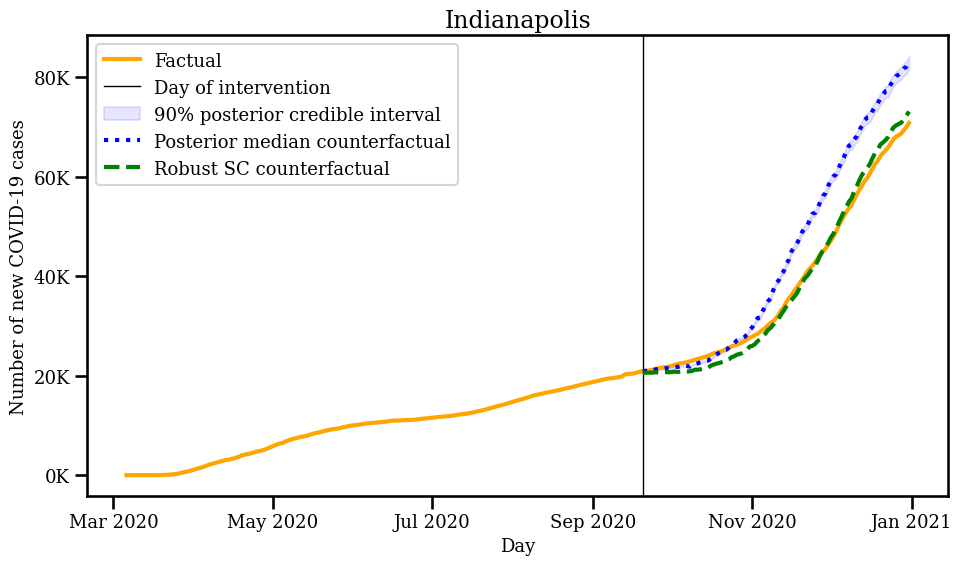

In [13]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
sns.set_context('talk')
# Enable LaTeX text rendering
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'

# Format y-ticks to show 'K' for thousands
def thousands_formatter(x, pos):
    return '%1.0fK' % (x*1e-3)

def plot_counterfactual_trajectories(total_pivot, intervention_t, counterfactual_preds, rsc_test_pred, team, fig_path=None):
    all_outcomes_TN = total_pivot.values
    dates = pd.to_datetime(total_pivot.index)

    plt.plot(dates, all_outcomes_TN[:, -1], color='orange', lw=3, label='Factual')
    plt.axvline(dates[intervention_t], color='k', lw=1, linestyle='-', label='Day of intervention')
    
    # Compute percentiles and median across trajectories for each time point
    lower_bound = np.percentile(counterfactual_preds, 5, axis=0)
    upper_bound = np.percentile(counterfactual_preds, 95, axis=0)
    median_trajectory = np.median(counterfactual_preds, axis=0)

    post_dates = dates[intervention_t:]
    plt.fill_between(post_dates, lower_bound, upper_bound, color='blue', alpha=0.1, label='90% posterior credible interval')
    plt.plot(post_dates, median_trajectory, color='blue', linestyle=':', lw=3, label='Posterior median counterfactual')
    plt.plot(post_dates, rsc_test_pred, color='green', linestyle='--', lw=3, label='Robust SC counterfactual')
    plt.legend(fontsize=13)
    plt.title(team, fontsize=17)
    plt.xlabel('Day', fontsize=13)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 3, 5, 7, 9, 11]))  # Every month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Month and year
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Number of new COVID-19 cases', fontsize=13)

    plt.gcf().set_size_inches(10, 6)  # Set the figure size (width, height)
    plt.tight_layout() 
    if fig_path is not None:
        plt.savefig(fig_path, format='pdf', dpi=1000)
        plt.close()
    else:
        plt.show()

plot_counterfactual_trajectories(total_pivot=total_pivot, 
                                 intervention_t=intervention_t, 
                                 counterfactual_preds=counterfactual_preds, 
                                 rsc_test_pred=rsc_test_pred,
                                 team=TEAM,
                                 fig_path=None)


### Book-keeping: copy rSC results

In [14]:
REPLICATION_SUPDIR = Path('/net/projects/schein-lab/jshou/replication/')

teams = [team for team in latent_dim_dict.keys() if team != 'Arizona']
for team in tqdm(teams):
    team_outdir = REPLICATION_SUPDIR.joinpath(team)
    team_outdir.makedirs_p()

    # load rSC results
    rsc_results_file = Path(f'/net/projects/schein-lab/jshou/rSC_replications/RBSC_Replications/{team}/train_data.pt')
    assert rsc_results_file.exists(), f'{team} has no rSC results'
    
    rsc_pred = np.array(torch.load(rsc_results_file))

    # copy results to new results folder
    rsc_team_outdir = team_outdir.joinpath('rSC')
    rsc_team_outdir.joinpath('rSC').makedirs_p()
    np.save(rsc_team_outdir.joinpath('rsc_pred.npy'), rsc_pred)

  0%|          | 0/31 [00:00<?, ?it/s]

### Putting it all together and running on multiple teams

In [14]:
import itertools as it

DATA_SUPDIR = Path('/net/projects/schein-lab/jshou/dat/')
RESULTS_SUPDIR = Path('/net/projects/schein-lab/jshou/Posterior_Checks/')
REPLICATION_SUPDIR = Path('/net/projects/schein-lab/jshou/replication/')

# this is where we will save all new plots
FIG_DIR = RESULTS_SUPDIR.joinpath('plots')

teams = [team for team in latent_dim_dict.keys() if team != 'Arizona']
for team in tqdm(teams):
    team_outdir = REPLICATION_SUPDIR.joinpath(team)
    team_outdir.makedirs_p()

    # load data
    total_pivot, intervention_t = load_team_data(team)
    all_outcomes_TN = total_pivot.values
    n_timesteps, n_counties = all_outcomes_TN.shape

    # load rSC counterfactual predictions
    rsc_pred_file = REPLICATION_SUPDIR.joinpath(team, 'rSC', 'rsc_pred.npy')
    if not rsc_pred_file.exists():
        print(f"No rSC results for {team}")
        continue

    rsc_pred = np.load(rsc_pred_file)
    rsc_test_pred = rsc_pred[intervention_t:]

    for model in ['GAP']:
        posterior_samples_files = RESULTS_SUPDIR.joinpath(team).files(f'{model}_posterior_samples_*.pth')
        
        for posterior_samples_file in posterior_samples_files:
            # load posterior samples
            posterior_samples = torch.load(posterior_samples_file)
            Z_samples = np.array(posterior_samples['Z'])
            assert Z_samples[0].shape[1] == n_counties
            latent_dim = Z_samples[0].shape[0]

            # create directory for model, team, and K
            model_team_k_outdir = team_outdir.joinpath(model, f'K_{latent_dim}')
            model_team_k_outdir.makedirs_p()

            # save out posterior samples
            np.save(model_team_k_outdir.joinpath('Z_samples.npy'), Z_samples)
            
            for reg_type, include_previous_outcome in it.product(['Ridge'], [True, False]):
                final_outdir = model_team_k_outdir.joinpath(f'reg_type_{reg_type}', f'include_prev_{include_previous_outcome}')
                final_outdir.makedirs_p()
                if final_outdir.joinpath('counterfactuals.npy').exists():
                    continue

                # compute counterfactuals for every posterior sample using Ridge regression
                counterfactual_preds = []
                for Z in tqdm(Z_samples):
                    cf_pred, best_reg = get_counterfactual_from_best_reg(Z,
                                                                reg_type=reg_type,
                                                                all_outcomes_TN=all_outcomes_TN, 
                                                                intervention_t=intervention_t, 
                                                                include_previous_outcome=include_previous_outcome)
                    counterfactual_preds.append(cf_pred)
                counterfactual_preds = np.array(counterfactual_preds)



                np.save(final_outdir.joinpath('counterfactuals.npy'), counterfactual_preds)

                fig_path = final_outdir.joinpath(f'{team}_K-{latent_dim}_include-{include_previous_outcome}_regtype-{reg_type}_plot.pdf')
                plot_counterfactual_trajectories(total_pivot=total_pivot, 
                                                 intervention_t=intervention_t, 
                                                 counterfactual_preds=counterfactual_preds, 
                                                 rsc_test_pred=rsc_test_pred,
                                                 team=team,
                                                 fig_path=fig_path)
                print(fig_path)
        

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/Buffalo/GAP/K_25/reg_type_Ridge/include_prev_True/Buffalo_K-25_include-True_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/Buffalo/GAP/K_25/reg_type_Ridge/include_prev_False/Buffalo_K-25_include-False_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/Buffalo/GAP/K_10/reg_type_Ridge/include_prev_True/Buffalo_K-10_include-True_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/Buffalo/GAP/K_10/reg_type_Ridge/include_prev_False/Buffalo_K-10_include-False_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/Buffalo/GAP/K_5/reg_type_Ridge/include_prev_True/Buffalo_K-5_include-True_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/Buffalo/GAP/K_5/reg_type_Ridge/include_prev_False/Buffalo_K-5_include-False_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/Buffalo/GAP/K_15/reg_type_Ridge/include_prev_True/Buffalo_K-15_include-True_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/Buffalo/GAP/K_15/reg_type_Ridge/include_prev_False/Buffalo_K-15_include-False_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/Buffalo/GAP/K_20/reg_type_Ridge/include_prev_True/Buffalo_K-20_include-True_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/Buffalo/GAP/K_20/reg_type_Ridge/include_prev_False/Buffalo_K-20_include-False_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/LA Chargers/GAP/K_10/reg_type_Ridge/include_prev_True/LA Chargers_K-10_include-True_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/LA Chargers/GAP/K_10/reg_type_Ridge/include_prev_False/LA Chargers_K-10_include-False_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.38642e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.51293e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.01947e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.49614e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.

/net/projects/schein-lab/jshou/replication/LA Chargers/GAP/K_5/reg_type_Ridge/include_prev_True/LA Chargers_K-5_include-True_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.01688e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.36802e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.68325e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.02044e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.

/net/projects/schein-lab/jshou/replication/LA Chargers/GAP/K_5/reg_type_Ridge/include_prev_False/LA Chargers_K-5_include-False_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.70565e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.51565e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.90013e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.82182e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.

/net/projects/schein-lab/jshou/replication/LA Chargers/GAP/K_20/reg_type_Ridge/include_prev_True/LA Chargers_K-20_include-True_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.67696e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.14046e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.38658e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.75165e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.

/net/projects/schein-lab/jshou/replication/LA Chargers/GAP/K_20/reg_type_Ridge/include_prev_False/LA Chargers_K-20_include-False_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/LA Rams/GAP/K_8/reg_type_Ridge/include_prev_True/LA Rams_K-8_include-True_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/LA Rams/GAP/K_8/reg_type_Ridge/include_prev_False/LA Rams_K-8_include-False_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.12513e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.87151e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.45115e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.72747e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.

/net/projects/schein-lab/jshou/replication/LA Rams/GAP/K_10/reg_type_Ridge/include_prev_True/LA Rams_K-10_include-True_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/LA Rams/GAP/K_10/reg_type_Ridge/include_prev_False/LA Rams_K-10_include-False_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.35208e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.65548e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.3178e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.10041e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.1

/net/projects/schein-lab/jshou/replication/LA Rams/GAP/K_5/reg_type_Ridge/include_prev_True/LA Rams_K-5_include-True_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.69962e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.19044e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.54144e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.36776e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/schein/miniconda3/lib/python3.

/net/projects/schein-lab/jshou/replication/LA Rams/GAP/K_5/reg_type_Ridge/include_prev_False/LA Rams_K-5_include-False_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/LA Rams/GAP/K_15/reg_type_Ridge/include_prev_True/LA Rams_K-15_include-True_regtype-Ridge_plot.pdf


  0%|          | 0/2000 [00:00<?, ?it/s]

/net/projects/schein-lab/jshou/replication/LA Rams/GAP/K_15/reg_type_Ridge/include_prev_False/LA Rams_K-15_include-False_regtype-Ridge_plot.pdf


## Plot all on a single plot

In [15]:
best_latent_dim_dict = {
    'Atlanta': [7],
    'Baltimore': [15],
    'Chicago': [20],
    'Cincinnati': [5, 10],
    'Cleveland': [12],
    'Dallas': [20, 37],
    'Denver': [5],
    'Detroit': [10],
    'Green Bay': [5, 15],
    'Indianapolis': [10, 15, 20],
    'Jacksonville': [20],
    'Kansas City': [5],
    'Las Vegas': [12, 20],
    'Minnesota': [5],
    'NY Giants': [10],
    'NY Jets': [7, 10],
    'New England': [9],
    'New Orleans': [20],
    'Philadelphia': [15],
    'Pittsburgh': [5, 15, 20, 25],
    'San Francisco': [15],
    'Seattle': [5],
    'Tampa Bay': [10],
    'Tennessee': [13],
    'Washington': [5]
 }

fans_allowed_dict = {
    'Atlanta': True,
    'Baltimore': True,
    'Buffalo': False,
    'Carolina': True, 
    'Chicago': False,
    'Cincinnati': True,
    'Cleveland': True,
    'Dallas': True,
    'Denver': True,
    'Detroit': False,
    'Green Bay': False,
    'Houston': True, 
    'Indianapolis': True, 
    'Jacksonville': True,
    'Kansas City': True,
    'Las Vegas': False,
    'LA Chargers': False,
    'LA Rams': False,
    'Miami': True,
    'Minnesota': False, 
    'New England': False, 
    'New Orleans': False,
    'NY Giants': False,
    'NY Jets': False,
    'Philadelphia': True,
    'Pittsburgh': True,
    'San Francisco': False,
    'Seattle': False,
    'Tampa Bay': True,
    'Tennessee': True,
    'Washington': False
}

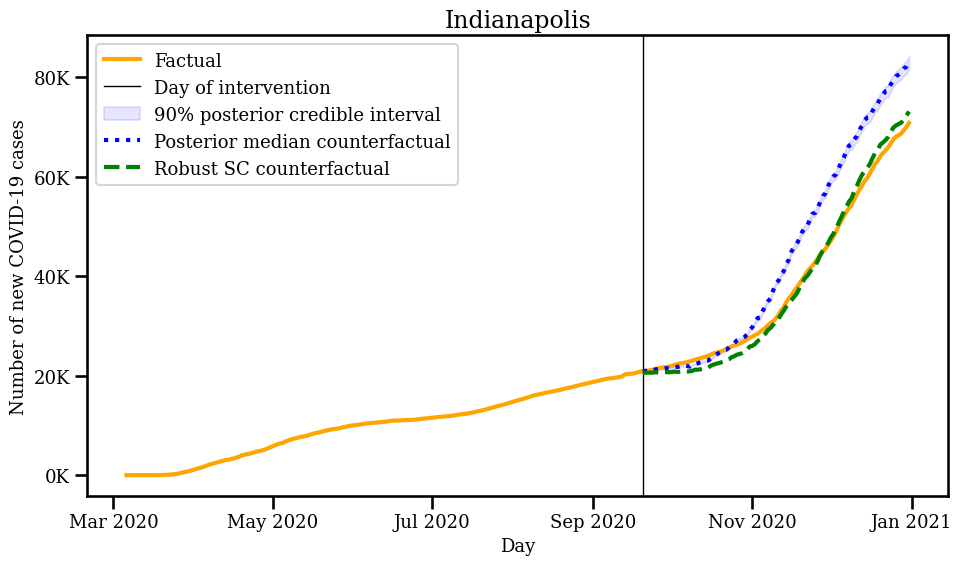

In [16]:

def plot_counterfactual_trajectories(total_pivot, intervention_t, counterfactual_preds, rsc_test_pred, team, fig_path=None):
    all_outcomes_TN = total_pivot.values
    dates = pd.to_datetime(total_pivot.index)

    plt.plot(dates, all_outcomes_TN[:, -1], color='orange', lw=3, label='Factual')
    plt.axvline(dates[intervention_t], color='k', lw=1, linestyle='-', label='Day of intervention')
    
    # Compute percentiles and median across trajectories for each time point
    lower_bound = np.percentile(counterfactual_preds, 5, axis=0)
    upper_bound = np.percentile(counterfactual_preds, 95, axis=0)
    median_trajectory = np.median(counterfactual_preds, axis=0)

    post_dates = dates[intervention_t:]
    plt.fill_between(post_dates, lower_bound, upper_bound, color='blue', alpha=0.1, label='90% posterior credible interval')
    plt.plot(post_dates, median_trajectory, color='blue', linestyle=':', lw=3, label='Posterior median counterfactual')
    plt.plot(post_dates, rsc_test_pred, color='green', linestyle='--', lw=3, label='Robust SC counterfactual')
    plt.legend(fontsize=13)
    plt.title(team, fontsize=17)
    plt.xlabel('Day', fontsize=13)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 3, 5, 7, 9, 11]))  # Every month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Month and year
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Number of new COVID-19 cases', fontsize=13)

    plt.gcf().set_size_inches(10, 6)  # Set the figure size (width, height)
    plt.tight_layout() 
    if fig_path is not None:
        plt.savefig(fig_path, format='pdf', dpi=1000)
        plt.close()
    else:
        plt.show()

plot_counterfactual_trajectories(total_pivot=total_pivot, 
                                 intervention_t=intervention_t, 
                                 counterfactual_preds=counterfactual_preds, 
                                 rsc_test_pred=rsc_test_pred,
                                 team=TEAM,
                                 fig_path=None)

/home/schein/Synthetic-Control-Paper-Model/fig/GAP_regtype-Ridge_include-True_fans-True.pdf
/home/schein/Synthetic-Control-Paper-Model/fig/GAP_regtype-Ridge_include-True_fans-False.pdf


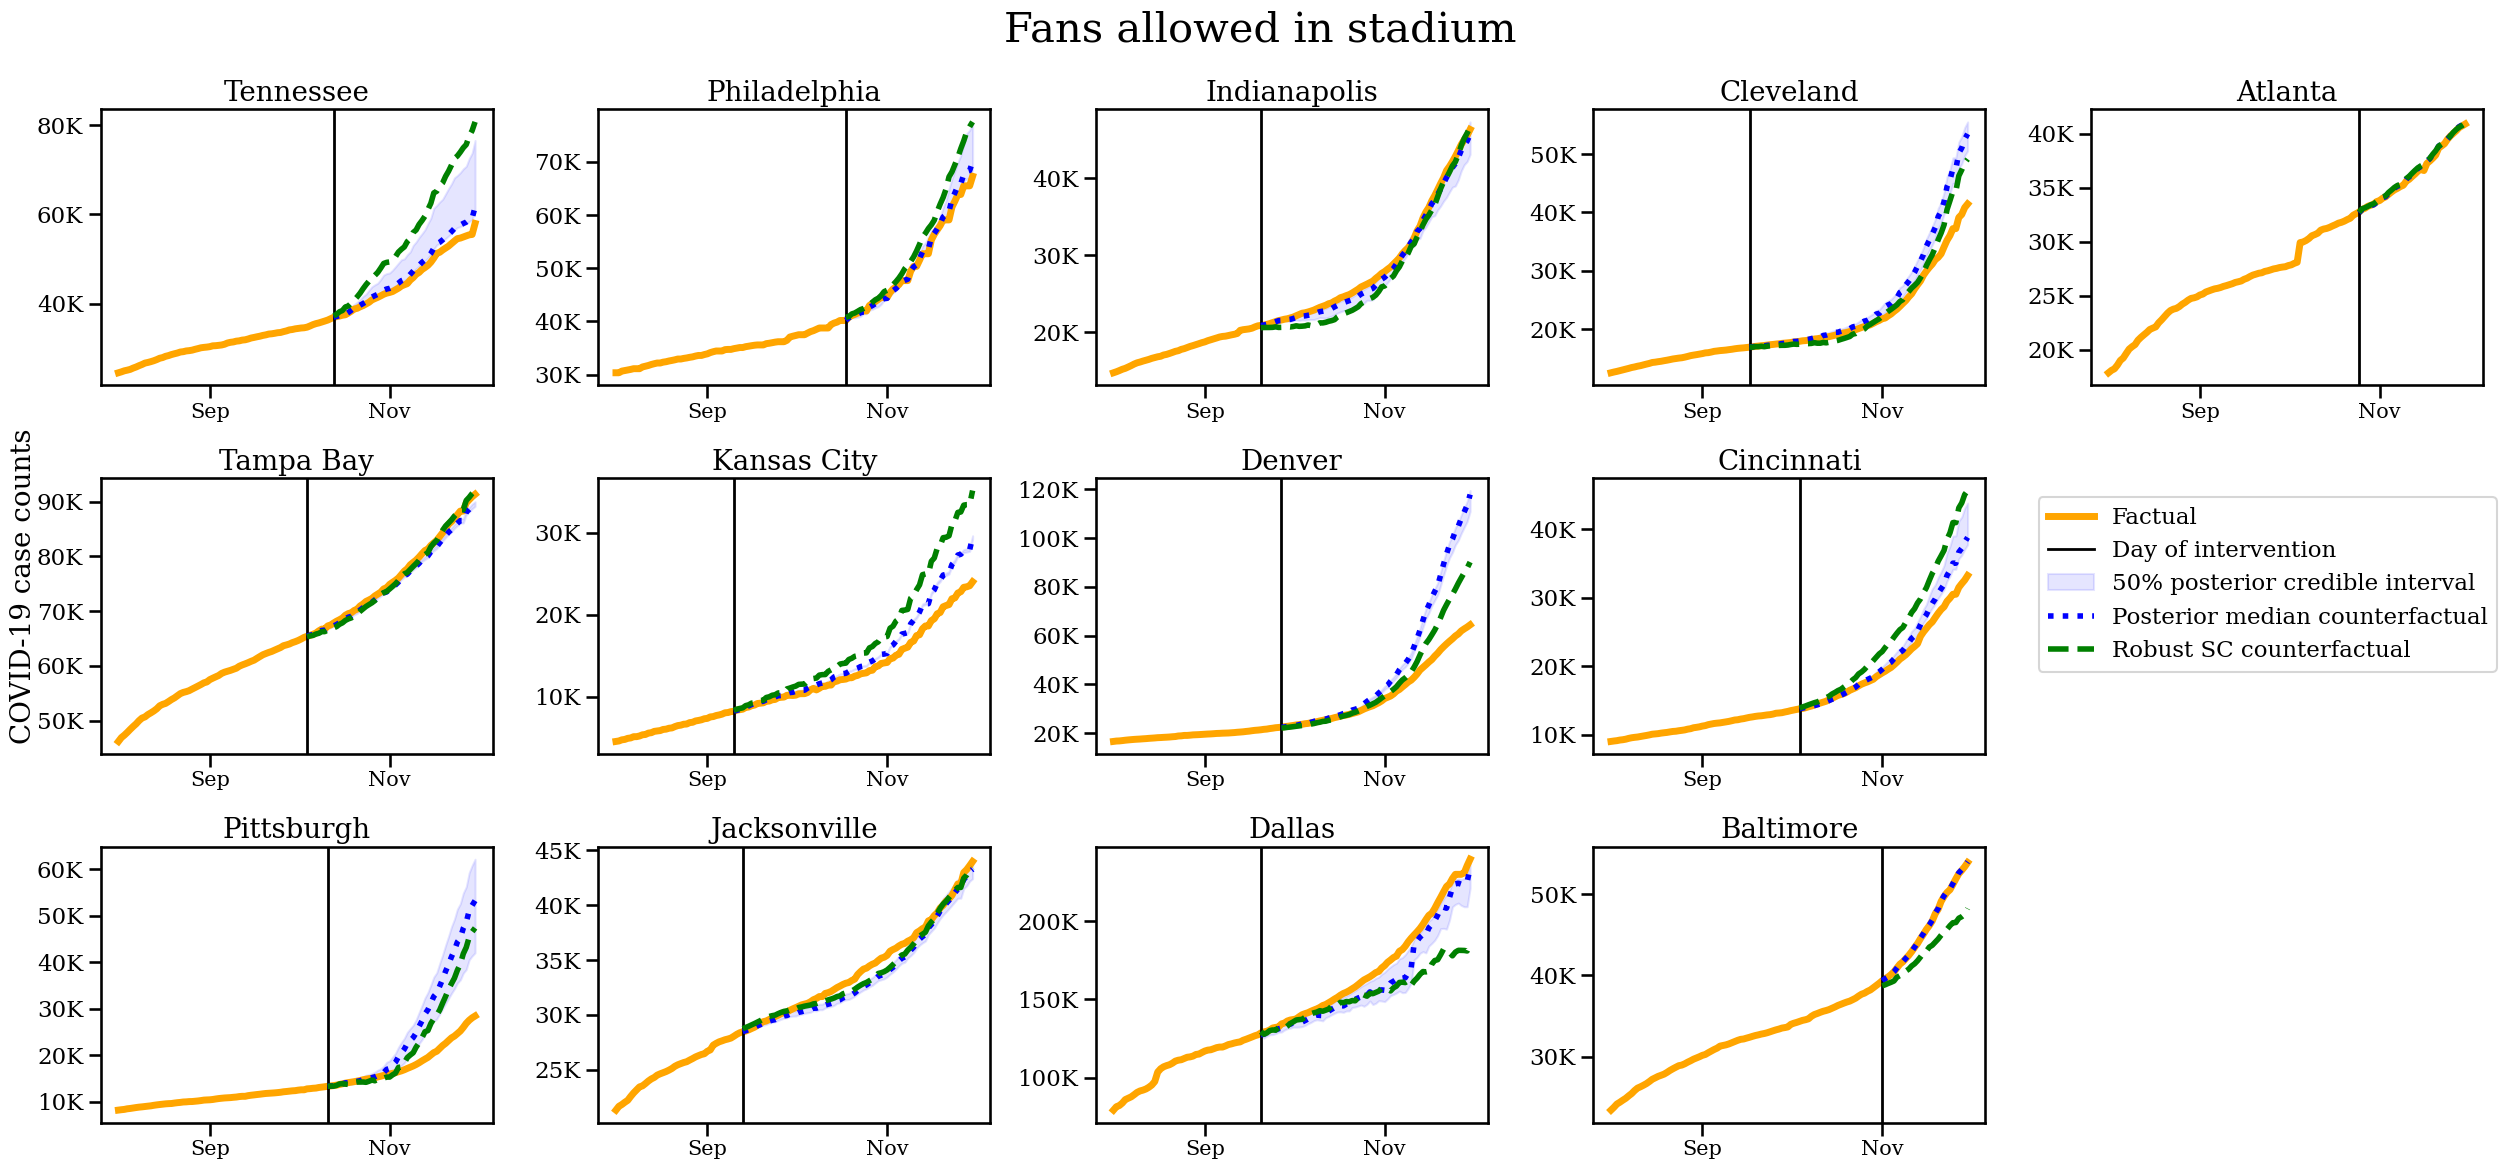

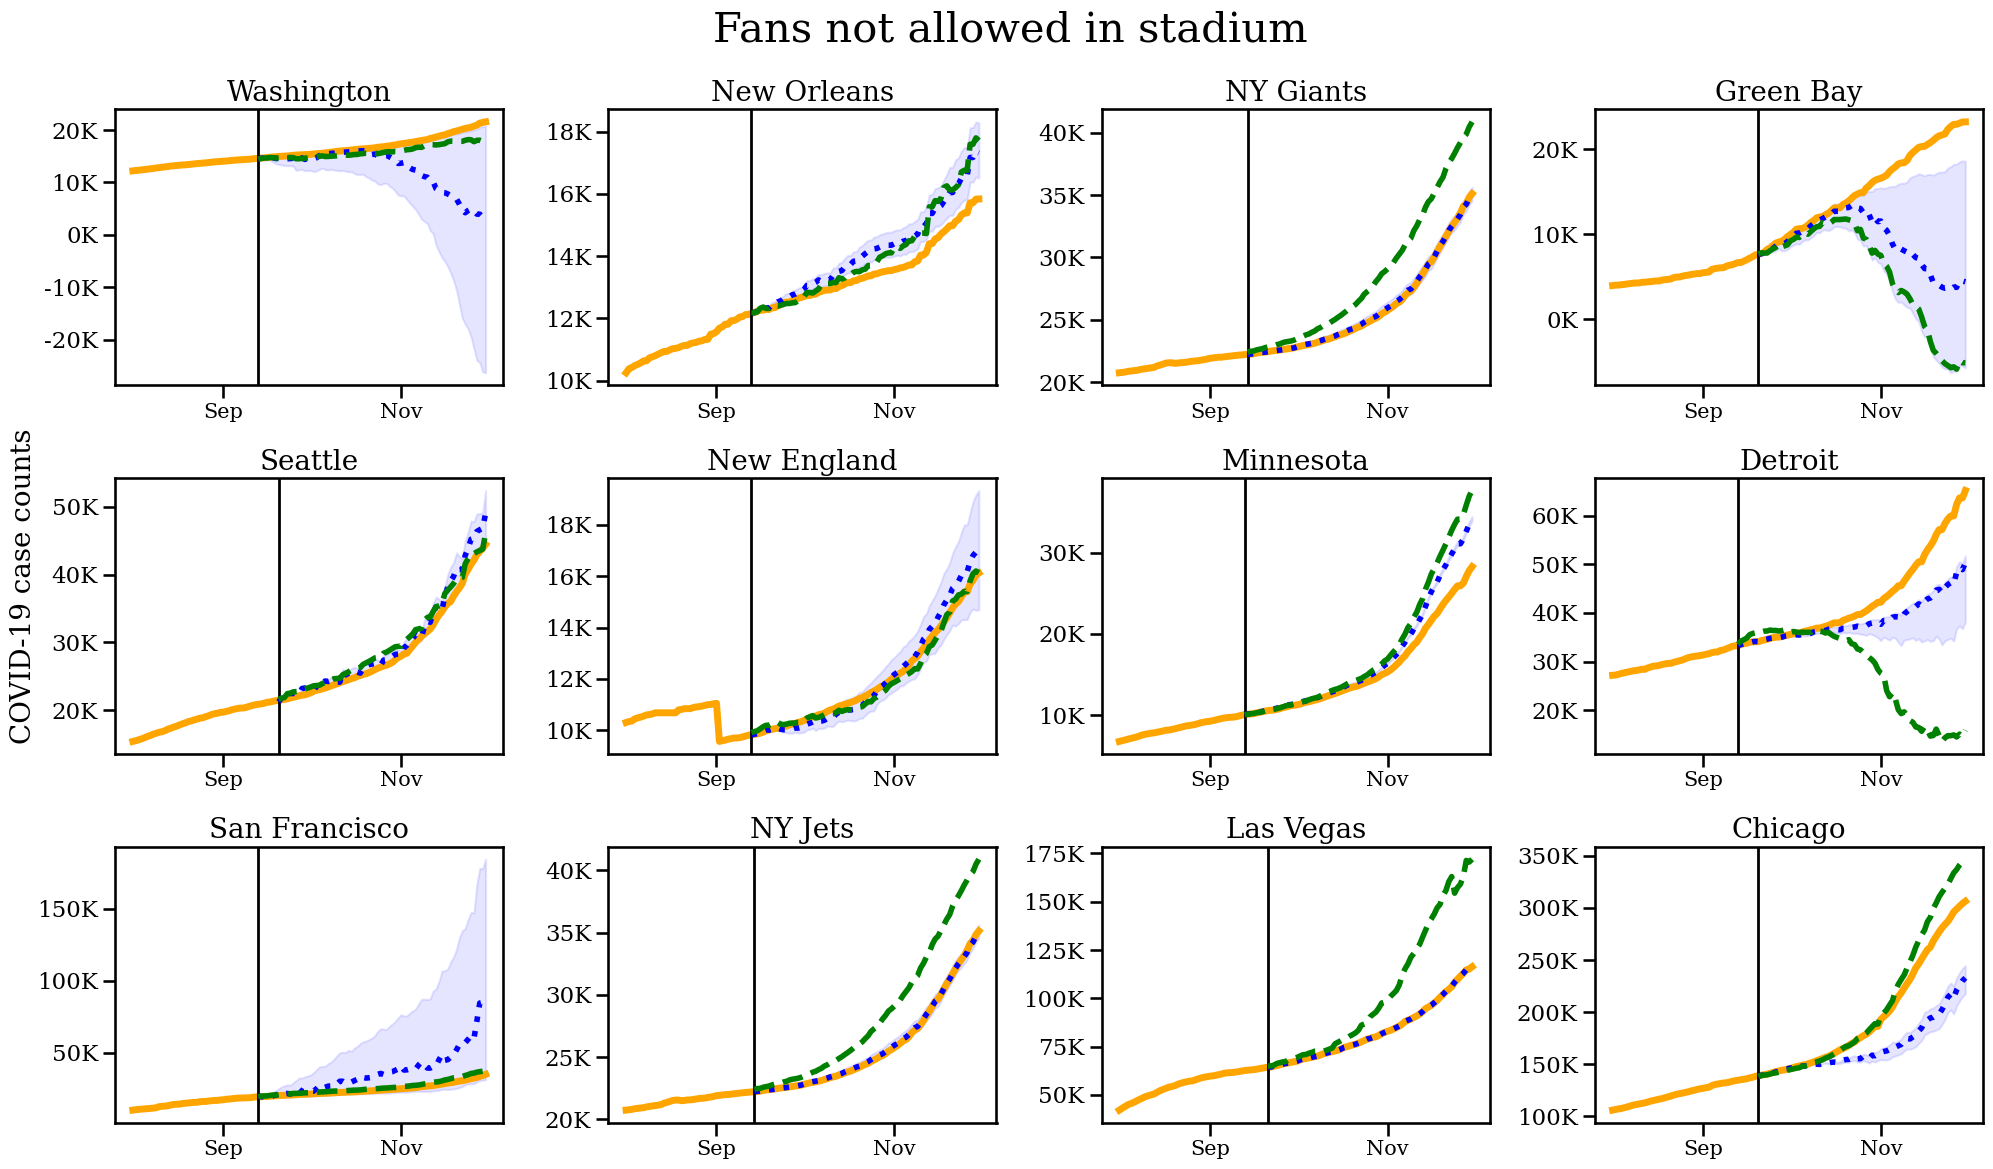

In [19]:
# this is where we will save all new plots
FIG_DIR = RESULTS_SUPDIR.joinpath('plots')
FIG_DIR.makedirs_p()

FIG_DIR = Path('/home/schein/Synthetic-Control-Paper-Model/fig')

model = 'GAP'
reg_type = 'Ridge'
include_previous_outcome = True
fans_allowed = True

for fans_allowed in [True, False]:
    teams = [team for team in latent_dim_dict.keys() if team in best_latent_dim_dict.keys()]

    if fans_allowed is not None:
        teams = [team for team in teams if fans_allowed_dict[team] == fans_allowed]
    teams = sorted(teams)

    n_teams = len(teams)
    # plot 2 rows of teams
    n_rows = 3
    n_cols = int(np.ceil(n_teams / n_rows))

    global_start_date = pd.to_datetime('2020-08-01')
    global_end_date = pd.to_datetime('2020-12-1')

    # create grid of axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    for col in range(n_cols):
        for row in range(n_rows):
            ax = axes[row, col]
            
            if not teams:
                ax.axis('off')
                continue

            team = teams.pop()

            # load data
            total_pivot, intervention_t = load_team_data(team)
            all_outcomes_TN = total_pivot.values
            n_timesteps, n_counties = all_outcomes_TN.shape
            all_outcomes_TN = total_pivot.values
            dates = pd.to_datetime(total_pivot.index)

            # load rSC counterfactual predictions
            rsc_pred_file = REPLICATION_SUPDIR.joinpath(team, 'rSC', 'rsc_pred.npy')
            assert rsc_pred_file.exists()
            rsc_pred = np.load(rsc_pred_file)
            rsc_test_pred = rsc_pred[intervention_t:]

            # load counterfactuals
            latent_dim = max(best_latent_dim_dict[team])
            subdirs = [team, model, f'K_{latent_dim}', f'reg_type_{reg_type}', f'include_prev_{include_previous_outcome}']
            final_outdir = REPLICATION_SUPDIR.joinpath(*subdirs)
            counterfactual_preds_file = final_outdir.joinpath('counterfactuals.npy')
            assert counterfactual_preds_file.exists()
            counterfactual_preds = np.load(counterfactual_preds_file)

            # find index of global_start_date and global_end_date and adjust 
            global_start_date_idx = np.where(dates == global_start_date)[0][0]
            global_end_date_idx = np.where(dates == global_end_date)[0][0]

            # plot
            ax.plot(dates[global_start_date_idx:global_end_date_idx], 
                    all_outcomes_TN[global_start_date_idx:global_end_date_idx][:, -1], 
                    color='orange', 
                    lw=5, 
                    label='Factual')
            
            ax.axvline(dates[intervention_t], 
                    color='k', 
                    lw=2, 
                    linestyle='-', 
                    label='Day of intervention')
            
            # Compute percentiles and median across trajectories for each time point
            lower_bound = np.percentile(counterfactual_preds, 25, axis=0)
            upper_bound = np.percentile(counterfactual_preds, 75, axis=0)
            median_trajectory = np.median(counterfactual_preds, axis=0)

            post_dates = dates[intervention_t:]
            global_end_post_date_idx = np.where(post_dates == global_end_date)[0][0]
            
            ax.fill_between(post_dates[:global_end_post_date_idx], 
                            lower_bound[:global_end_post_date_idx], 
                            upper_bound[:global_end_post_date_idx], 
                            color='blue', alpha=0.1, label='50% posterior credible interval')
            
            ax.plot(post_dates[:global_end_post_date_idx], 
                    median_trajectory[:global_end_post_date_idx], 
                    color='blue', linestyle=':', lw=4, label='Posterior median counterfactual')
            
            ax.plot(post_dates[:global_end_post_date_idx], 
                    rsc_test_pred[:global_end_post_date_idx], 
                    color='green', linestyle='--', lw=4, label='Robust SC counterfactual')
            # ax.legend(fontsize=13)
            ax.set_title(team, fontsize=20)
            # if row == n_rows - 1:
                    # ax.set_xlabel('Day', fontsize=30)

            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[5, 7, 9, 11]))  # Every month
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Month
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

            # change fontsize of xticks
            ax.tick_params(axis='x', which='major', labelsize=15) 

            # plot legend on an empty axis
            if row == 0 and col == 0 and fans_allowed:
                ax.legend(fontsize=15, loc='upper left')
                lines, labels = ax.get_legend_handles_labels()
                ax.legend().remove()
                fig.legend(lines, labels, loc='center right')

    # create space between subplots

    # set super y-label
    fig.text(0, 0.5, 'COVID-19 case counts', va='center', rotation='vertical', fontsize=20)

    # move plots to the right
    suptitle = 'Fans allowed in stadium' if fans_allowed else 'Fans not allowed in stadium'
    plt.suptitle(suptitle, fontsize=30)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.tight_layout()

    # save as pdf
    fig_path = FIG_DIR.joinpath(f'{model}_regtype-{reg_type}_include-{include_previous_outcome}_fans-{fans_allowed}.pdf')
    plt.savefig(fig_path, format='pdf', dpi=1000)
    print(fig_path)
